# 1. General description

Most investors have difficulty to buy stocks to compose their portifolio. Considering a dataset from [Status Invest](https://statusinvest.com.br/) webpage which contains several fundamental indicators for more than six hundred brazilian stocks, this work goals to make a score for some of these indicators in order to rank the stocks and help investors to chose the best stocks for their portifolio. Moreover, it was chosen the Dividend Yield indicator - which shows how much a company pays out in dividends each year relative to its stock price - to verify the best dividend paying companies after removing outliers by using HDBScan clustering algorithm.

# 2. Import libraries

In [2]:
import pandas as pd
import numpy as np
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Loading dataset

In [3]:
df_complete = pd.read_csv('./statusinvest-busca-avancada.csv', sep=";")

## 3.1 Dataset columns - Indicators

In [3]:
df_complete.keys()

Index(['TICKER', 'PRECO', 'DY', 'P/L', 'P/VP', 'P/ATIVOS', 'MARGEM BRUTA',
       'MARGEM EBIT', 'MARG. LIQUIDA', 'P/EBIT', 'EV/EBIT',
       'DIVIDA LIQUIDA / EBIT', 'DIV. LIQ. / PATRI.', 'PSR', 'P/CAP. GIRO',
       'P. AT CIR. LIQ.', 'LIQ. CORRENTE', 'ROE', 'ROA', 'ROIC',
       'PATRIMONIO / ATIVOS', 'PASSIVOS / ATIVOS', 'GIRO ATIVOS',
       'CAGR RECEITAS 5 ANOS', 'CAGR LUCROS 5 ANOS', ' LIQUIDEZ MEDIA DIARIA',
       ' VPA', ' LPA', ' PEG Ratio', ' VALOR DE MERCADO'],
      dtype='object')

## 3.2 Score functions

In [4]:
# P/L
def pl(value):
    if pd.isna(value):
        return
    
    if value < 0 or value > 100:
        score = 0
    elif 0 <= value < 10:
        score = 0.05 * value + 4.5
    elif 10 <= value < 15:
        score = 0.1 * (value - 10) + 4
    elif 15 <= value < 20:
        score = 0.2 * (value - 15) + 3
    elif 20 <= value < 30:
        score = 3
    else:
        score = (300 - 3 * value) / 70

    return score

# P/VP
def pvp(value):
    if pd.isna(value):
        return
    
    if value < 0:
        score = 0
    elif 0 <= value < 1:
        score = 5
    elif 1 <= value < 3:
        score = 6 - value
    elif 3 <= value < 20:
        score = -(3 / 17) * (value - 3) + 3
    else:
        score = 0
    return score


In [5]:
# Margem Líquida
def margem_liquida(value):
    if pd.isna(value):
        return
    
    if value < 0:
        score = 0
    elif 0 <= value < 5:
        score = 0.7 * value
    elif 5 <= value < 10:
        score = 0.3 * value + 2
    else:
        score = 5
    return score

# ROE
def roe(value):
    if pd.isna(value):
        return
    
    if value < 0:
        score = 0
    elif 0 <= value < 10:
        score = 0.35 * value
    elif 10 <= value < 15:
        score = (3 * value + 5) / 10
    else:
        score = 5
    return score

# CAGR dos Lucros dos últimos 5 anos
def cagr_lucros(value):
    return roe(value)

In [6]:
# Liquidez Corrente
def liquidez_corrente(value):
    if pd.isna(value):
        return
    
    if value < 0:
        score = 0
    elif 0 <= value < 2:
        score = 1.5 * value
    elif 2 <= value < 3:
        score = 2 * (value - 2) + 3
    else:
        score = 5
    return score

# Dívida Líquida / PL
def divida_liquida_pl(value):
    if pd.isna(value):
        return
    
    if value < 1.2:
        score = 5
    elif 1.2 <= value < 20:
        score = (5 / 18.8) * (value - 20) + 5
    else:
        score = 0
    return score

# Dívida Líquida/EBIT
def divida_liquida_sobre_ebit(value):
    if pd.isna(value):
        return
    
    if value < 0:
        score = 0
    elif 0 <= value < 3:
        score = (12 - 3 * value) / 4
    elif 3 <= value < 20:
        score = (68 - 4 * value) / 17
    else:
        score = 0
    return score

## 3.3 Get dataframe with only the indicators that have scoring function

In [7]:
df_feat = pd.DataFrame()
df_feat = df_complete[['TICKER', 'PRECO', 'DY', 'P/L', 'P/VP', 'MARG. LIQUIDA',
                       'DIVIDA LIQUIDA / EBIT', 'DIV. LIQ. / PATRI.',
                       'LIQ. CORRENTE', 'ROE', 'CAGR LUCROS 5 ANOS']]

In [8]:
df_feat.head(10)

,TICKER,PRECO,DY,P/L,P/VP,MARG. LIQUIDA,DIVIDA LIQUIDA / EBIT,DIV. LIQ. / PATRI.,LIQ. CORRENTE,ROE,CAGR LUCROS 5 ANOS
0,AALR3,"17,78",NaN,"-10,99","3,00","-22,50","-50,55","0,95","0,63","-27,28",NaN
1,ABCB4,"18,39","8,17","5,60","0,82","17,25",NaN,NaN,"0,13","14,65","12,65"
2,ABEV3,"14,25","5,32","15,82","2,66","17,26","-0,47","-0,10","1,01","16,78","14,46"
3,ADHM3,"1,56",NaN,"-4,09","-1,29","-18.860,61","0,00",NaN,"0,00","-31,47",NaN
4,AERI3,"1,16",NaN,"-7,78","1,05","-4,20","3,87","1,14","1,93","-13,47",NaN
5,AESB3,"10,86","0,98","45,34","1,49","4,68","9,82","1,89","1,64","3,29",NaN
6,AFLT3,"9,50","2,77","15,23","2,20","48,96","-0,47","-0,07","4,34","14,46","25,66"
7,AGRO3,"23,49","12,75","45,67","1,28","4,93","10,60","0,32","2,25","2,79","15,83"
8,AGXY3,"5,09","0,84","18,21","0,56","0,39","2,09","0,84","1,10","3,06",NaN
9,AHEB3,"22,09",NaN,"2,87","26,05","15,94","-0,40","-5,56","1,34","908,67",NaN


Notice that the dataframe `df_feat` is composed by values in string and separated by comma.

In [9]:
df_feat.dtypes

TICKER                   object
PRECO                    object
DY                       object
P/L                      object
P/VP                     object
MARG. LIQUIDA            object
DIVIDA LIQUIDA / EBIT    object
DIV. LIQ. / PATRI.       object
LIQ. CORRENTE            object
ROE                      object
CAGR LUCROS 5 ANOS       object
dtype: object

In [10]:
type(df_feat.iloc[0, 1])

str

Lets convert these strings to float separated by dot. 

In [11]:
def convert_to_float(value):
    if isinstance(value, str):
        return float(value.replace('.', '').replace(',', '.'))

In [12]:
df_feat = pd.concat([df_feat.TICKER, df_feat.iloc[:, 1:].applymap(convert_to_float)], axis=1)
df_feat.head(10)

,TICKER,PRECO,DY,P/L,P/VP,MARG. LIQUIDA,DIVIDA LIQUIDA / EBIT,DIV. LIQ. / PATRI.,LIQ. CORRENTE,ROE,CAGR LUCROS 5 ANOS
0,AALR3,17.78,NaN,-10.99,3.00,-22.50,-50.55,0.95,0.63,-27.28,NaN
1,ABCB4,18.39,8.17,5.60,0.82,17.25,NaN,NaN,0.13,14.65,12.65
2,ABEV3,14.25,5.32,15.82,2.66,17.26,-0.47,-0.10,1.01,16.78,14.46
3,ADHM3,1.56,NaN,-4.09,-1.29,-18860.61,0.00,NaN,0.00,-31.47,NaN
4,AERI3,1.16,NaN,-7.78,1.05,-4.20,3.87,1.14,1.93,-13.47,NaN
5,AESB3,10.86,0.98,45.34,1.49,4.68,9.82,1.89,1.64,3.29,NaN
6,AFLT3,9.50,2.77,15.23,2.20,48.96,-0.47,-0.07,4.34,14.46,25.66
7,AGRO3,23.49,12.75,45.67,1.28,4.93,10.60,0.32,2.25,2.79,15.83
8,AGXY3,5.09,0.84,18.21,0.56,0.39,2.09,0.84,1.10,3.06,NaN
9,AHEB3,22.09,NaN,2.87,26.05,15.94,-0.40,-5.56,1.34,908.67,NaN


## 3.4 Input the score of each indicator in dataframe

Since for each indicator of a stock one have a score, the column `total_score` was defined as the mean of these scores. Hence each stock have an only `total_score`. Lets order this dataframe from the companies with the best score to the companies with worst score

In [13]:
df_feat['pl_score'] = df_feat['P/L'].apply(pl)
df_feat['p/vp_score'] = df_feat['P/VP'].apply(pvp)
df_feat['margem_líquida_score'] = df_feat['MARG. LIQUIDA'].apply(margem_liquida)
df_feat['div/ebit_score'] = df_feat['DIVIDA LIQUIDA / EBIT'].apply(divida_liquida_sobre_ebit)
df_feat['div/pl_score'] = df_feat['DIV. LIQ. / PATRI.'].apply(divida_liquida_pl)
df_feat['liquidez_corrente'] = df_feat['LIQ. CORRENTE'].apply(liquidez_corrente)
df_feat['roe_score'] = df_feat['ROE'].apply(roe)
df_feat['cagr_lucros_score'] = df_feat['CAGR LUCROS 5 ANOS'].apply(cagr_lucros)
df_feat['total_score'] = df_feat.iloc[:, 11:19].apply(lambda x: x.mean(), axis=1)

df_feat = df_feat.sort_values('total_score', ascending=False)
df_feat.head(20)

,TICKER,PRECO,DY,P/L,P/VP,MARG. LIQUIDA,DIVIDA LIQUIDA / EBIT,DIV. LIQ. / PATRI.,LIQ. CORRENTE,ROE,CAGR LUCROS 5 ANOS,pl_score,p/vp_score,margem_líquida_score,div/ebit_score,div/pl_score,liquidez_corrente,roe_score,cagr_lucros_score,total_score
47,BBAS3,46.94,9.63,4.17,0.82,12.35,NaN,NaN,12.76,20.01,25.08,4.7085,5.00,5.000,NaN,NaN,5.00,5.000,5.000,4.951417
275,FNCN3,14.25,3.75,3.14,0.95,116.83,NaN,NaN,6.36,30.37,61.75,4.6570,5.00,5.000,NaN,NaN,5.00,5.000,5.000,4.942833
76,BNBR3,89.76,6.09,3.69,0.82,24.48,NaN,NaN,NaN,22.21,24.10,4.6845,5.00,5.000,NaN,NaN,NaN,5.000,5.000,4.936900
46,BAZA3,68.91,7.58,3.31,0.76,34.28,NaN,NaN,NaN,23.12,79.20,4.6655,5.00,5.000,NaN,NaN,NaN,5.000,5.000,4.933100
70,BMEB4,13.05,4.20,6.73,1.01,5.24,NaN,NaN,NaN,15.91,25.14,4.8365,4.99,3.572,NaN,NaN,NaN,5.000,5.000,4.679700
425,NRTQ3,0.00,NaN,0.00,0.00,17.00,0.21,0.04,3.69,18.68,25.07,4.5000,5.00,5.000,2.842500,5.0,5.00,5.000,5.000,4.667813
69,BMEB3,14.30,3.20,8.03,1.20,5.24,NaN,NaN,NaN,15.91,25.14,4.9015,4.80,3.572,NaN,NaN,NaN,5.000,5.000,4.654700
56,BEES3,8.75,6.92,8.92,1.42,6.42,NaN,NaN,NaN,16.37,14.38,4.9460,4.58,3.926,NaN,NaN,NaN,5.000,4.814,4.653200
57,BEES4,9.97,6.28,9.83,1.57,6.42,NaN,NaN,NaN,16.37,14.38,4.9915,4.43,3.926,NaN,NaN,NaN,5.000,4.814,4.632300
289,GGBR4,25.80,13.81,4.75,0.93,12.54,0.46,0.13,2.94,19.52,NaN,4.7375,5.00,5.000,2.655000,5.0,4.88,5.000,NaN,4.610357


The dataframe `df_feat.head(20)` has a list of the best twenty stocks accornding to the scores above. Lets consider a histogram of these stocks.

<Axes: ylabel='TICKER'>

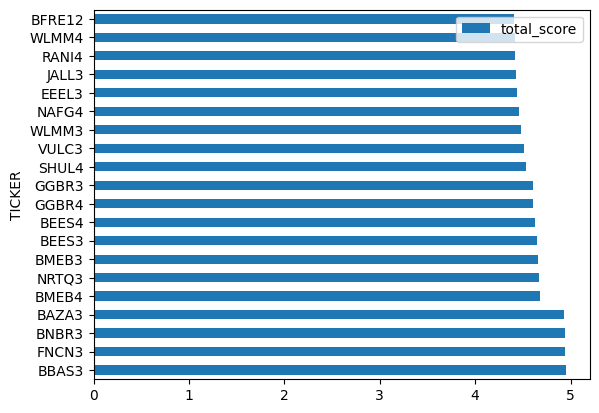

In [14]:
df_feat_view = pd.DataFrame()
df_feat_view.index = df_feat.TICKER
df_feat_view['total_score'] = df_feat['total_score'].values
df_feat_view.head(20).plot.barh()

# 4. Best dividend paying companies

Lets consider only the companies which the dividend yield data is not NaN. Moreover, the reordering of the index is important to apply the clustering algorithm.

In [15]:
df_div = pd.DataFrame(df_feat[['TICKER','DY']]).dropna()
df_div.index = range(len(df_div))
df_div

,TICKER,DY
0,BBAS3,9.63
1,FNCN3,3.75
2,BNBR3,6.09
3,BAZA3,7.58
4,BMEB4,4.20
...,...,...
334,MRVE3,1.45
335,DASA3,0.74
336,MODL4,0.80
337,MODL11,0.78


Since the standard deviation is quite high compared to the mean, this may indicate the existence of outliers. We will remove them using the hdbscan algorithm.

In [16]:
df_div.DY.std()

152.30421655985072

In [17]:
df_div.DY.mean()

15.393126843657813

Lets create a `clusterer` object and fit the `df_div.DY` data. Since it is 1D array, it must be reshaped.

In [18]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(np.asarray(df_div.DY).reshape(-1, 1))

The `clusterer` object has an attribute called `outlier_scores_` which provides a numpy array with a value for each sample in `df_div.DY` that was fit with the clusterer. The higher the score, the more likely the point is to be an outlier.

In [19]:
clusterer.outlier_scores_

array([4.92957746e-01, 1.48148148e-01, 0.00000000e+00, 2.34042553e-01,
       0.00000000e+00, 0.00000000e+00, 1.15384615e-01, 8.00000000e-02,
       7.44680851e-01, 8.54251012e-01, 8.00000000e-02, 1.36363636e-01,
       0.00000000e+00, 1.15384615e-01, 1.36363636e-01, 6.86956522e-01,
       2.50000000e-01, 4.16666667e-02, 7.69230769e-02, 5.86206897e-01,
       5.66265060e-01, 3.61111111e-01, 3.57142857e-01, 0.00000000e+00,
       0.00000000e+00, 3.03030303e-01, 4.16666667e-02, 3.89830508e-01,
       0.00000000e+00, 9.29961089e-01, 0.00000000e+00, 1.48148148e-01,
       7.69230769e-02, 0.00000000e+00, 8.65168539e-01, 3.03030303e-01,
       1.78571429e-01, 1.78571429e-01, 8.54251012e-01, 7.60000000e-01,
       1.48148148e-01, 0.00000000e+00, 4.16666667e-02, 5.38461538e-01,
       1.48148148e-01, 8.58267717e-01, 9.95323461e-01, 9.99868979e-01,
       4.16666667e-02, 5.38461538e-01, 6.75675676e-01, 5.00000000e-02,
       6.86956522e-01, 1.15384615e-01, 1.36363636e-01, 3.20754717e-01,
      

Lets look at the distributions of outlier scores.

/tmp/ipykernel_128702/3693830524.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)


<Axes: ylabel='Density'>

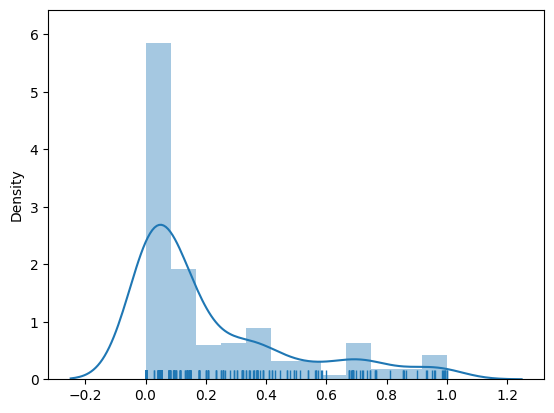

In [20]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

Most dividend yield is between 0 and 0.1

A threshold for the dividend yield is stablish (it is considered 99% of the sample).

In [21]:
threshold = np.percentile(clusterer.outlier_scores_, 99)
threshold

0.9929624037619289

Getting the index of the outliers.

In [22]:
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]

The chart below shows the outliers in red and the other dividend yield values in gray.

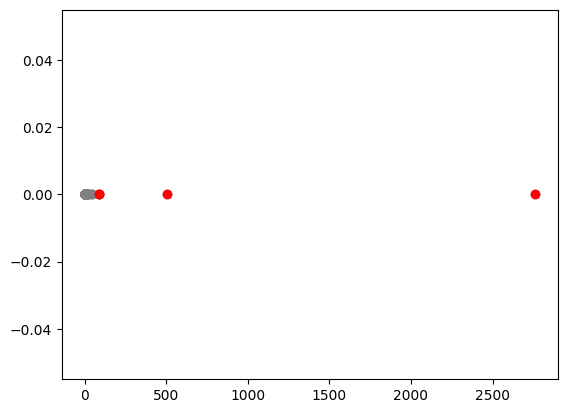

In [23]:
# plt.plot(df_div.DY.T, c='gray')
plt.scatter(df_div.DY.T, [0] * df_div.DY.T.shape[0], c='gray')
plt.scatter(df_div.DY[outliers], [0] * df_div.DY[outliers].shape[0], c='red')

The dataframe `df_outliers` below contains the companies with dividend yield outlier.

In [24]:
dic_outliers = {}
dic_outliers['TICKER'] = [df_div.iloc[idx, 0] for idx in outliers]
dic_outliers['DY'] = [df_div.iloc[idx, 1] for idx in outliers]
        
df_outliers = pd.DataFrame(dic_outliers)
df_outliers

,TICKER,DY
0,CORR4,91.30
1,CORR3,2762.62
2,MMAQ4,503.40
3,PPAR3,85.96


Finally, the dataframe `df_without_outliers` contains all stocks which have not outlier dividend yield and is ordered by this indicator.

In [26]:
df_without_outliers = df_div[~df_div.DY.isin(df_outliers.DY)].sort_values('DY', ascending=False)
df_without_outliers.head(20)

,TICKER,DY
97,PETR4,48.81
101,PETR3,44.53
113,CATA3,38.09
328,CSNA3,23.28
57,CMIN3,21.99
226,MRFG3,21.32
219,GRND3,19.15
29,BMKS3,18.14
132,CRPG6,16.42
34,UNIP3,15.16
